# Moving average trading

In [132]:
import os
import sys
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import TwoByTwoLayout
from ipywidgets import HBox, VBox, Label
from ipywidgets import interactive_output, jslink
from ipywidgets import FloatSlider, IntSlider, SelectionSlider, SelectionRangeSlider
from ipywidgets import FloatText, IntText, Dropdown
from IPython.display import display

import trading as tra
import trading_plots as trp
import trading_defaults as dft

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Default parameters

In [68]:
TICKER     = 'AAPL'

REFRESH    = False # Download fresh Yahoo data 

START_DATE = '2017-07-15'
END_DATE   = datetime.strftime(datetime.now()- timedelta(days = 1), '%Y-%m-%d') #yesterday
END_DATE = '2021-03-26'
print(END_DATE)

2021-03-26


### Data download

In [69]:
try:
    raw, ticker_name = tra.load_security(dirname = dft.DATA_DIR, 
                                        ticker  = TICKER, 
                                        refresh = REFRESH, 
                                        period  = dft.DEFAULT_PERIOD,
                                        )
    print (raw)
except IndexError:
        print(f'Could not load {TICKER}')
except:
    print(f'Error type {sys.exc_info()[0]}')
else:
    security = pd.DataFrame(raw[f'Close_{TICKER}'])
    security.rename(columns={f'Close_{TICKER}': "Close"},
                    inplace=True)

    security
    

Loading data from data/AAPL_5y.pkl
             Close_AAPL   Vol_AAPL
Date                              
2016-03-28   24.4595337   77645600
2016-03-29   25.0385265  124760400
2016-03-30   25.4756794  182404400
2016-03-31   25.3431377  103553600
2016-04-01   25.5756664  103496000
...                 ...        ...
2021-03-22  123.3899994  111912300
2021-03-23  122.5400009   95467100
2021-03-24  120.0899963   88530500
2021-03-25  120.5899963   98844700
2021-03-26  121.2099991   93958900

[1260 rows x 2 columns]


#### Setup default start & end dates

In [70]:
# Check dates 
#print(tra.get_title_dates(security, START_DATE, END_DATE))
print(tra.get_datetime_date_range(security, START_DATE, END_DATE))
#print(tra.get_filename_dates(security, START_DATE, END_DATE))

[datetime.datetime(2017, 7, 15, 0, 0), datetime.datetime(2021, 3, 26, 0, 0)]


## Plotting functions

In [71]:
def plot_time_series(span, date_range, fee_pct, buffer):
    trp.plot_time_series(TICKER, ticker_name, date_range, security,span, fee_pct, buffer)

In [72]:
def plot_span_range(buffer, n_best, fee_pct, date_range):
    trp.plot_span_range(buffer     = buffer, 
                        n_best     = n_best, 
                        fee_pct    = fee_pct, 
                        date_range = date_range, 
                        ticker     = TICKER, 
                        ticker_name = ticker_name,
                        security   = security, 
                       )

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs
 
*** Profile stats marshalled to file 'plot_span_range.prof'. 


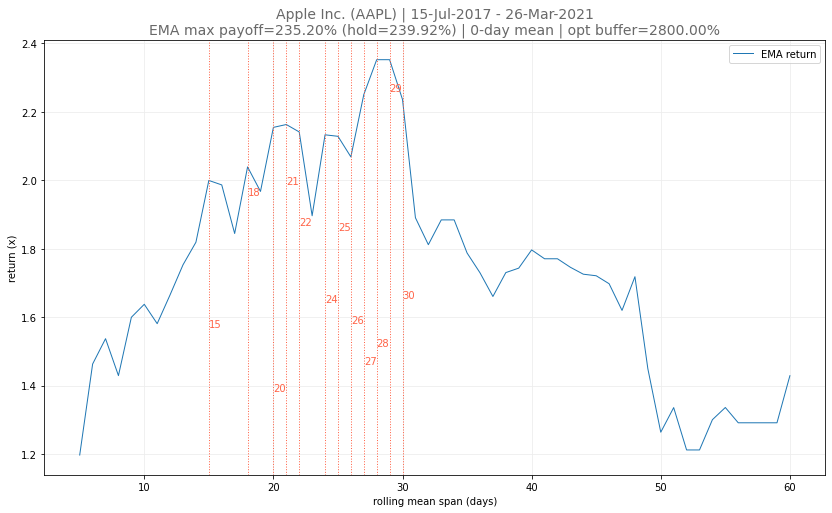

In [165]:
#### test driver for trp.plot_span_range
%time 
plot = True
if plot:
    %prun -D plot_span_range.prof 
    plot_span_range(buffer     = .01, 
                    n_best     = 12, 
                    fee_pct    = dft.FEE_PCT, 
                    date_range = [datetime.strptime(START_DATE, '%Y-%m-%d'), 
                                  datetime.strptime(END_DATE, '%Y-%m-%d')], 
                   )

In [74]:
def plot_buffer_range(span, n_best, fee_pct, date_range):
    trp.plot_buffer_range(span       = span, 
                          n_best     = n_best, 
                          fee_pct    = fee_pct, 
                          date_range = date_range, 
                          ticker     = TICKER, 
                          ticker_name = ticker_name,
                          security   = security, 
                         )

In [75]:
#### test driver for trp.plot_span_range
%time 
plot = False
if plot:
    %time plot_buffer_range(span       = 20, 
                            n_best     = 12, 
                            fee_pct    = dft.FEE_PCT, 
                            date_range = [datetime.strptime(START_DATE, '%Y-%m-%d'), 
                                          datetime.strptime(END_DATE, '%Y-%m-%d')], 
                            )

In [76]:
date_range = tra.get_datetime_date_range(security, START_DATE, END_DATE)
print(date_range)
#tra.read_ema_map(TICKER, date_range)
#ATO.PA_2017-07-15_2021-03-25_ema_map

[datetime.datetime(2017, 7, 15, 0, 0), datetime.datetime(2021, 3, 26, 0, 0)]


In [77]:
# Driver for plot_buffer_span_contours
%time 
plot = False
if plot:
    date_range = tra.get_datetime_date_range(security, START_DATE, END_DATE)
    
    print(tra.get_ema_map_filename(TICKER, date_range))
    if os.path.exists(tra.get_ema_map_filename(TICKER, date_range)):
        spans, buffers, emas, hold  = tra.read_ema_map(TICKER, date_range,)
    else: # If not saved, compute it
        spans, buffers, emas, hold = tra.build_ema_map(TICKER, security, date_range,)
    trp.plot_buffer_span_contours(TICKER, ticker_name, date_range, spans, buffers, emas, hold)
#ETH-USD_2017-07-15_2021-03-26_ema_map.csv

In [166]:
def plot_buffer_span_3D(azimuth, elevation, rdist, colors):
    trp.plot_buffer_span_3D(ticker      = TICKER,
                            ticker_name = ticker_name, 
                            date_range  = date_range, 
                            spans       = spans, 
                            buffers     = buffers, 
                            emas        = emas, 
                            hold        = hold, 
                            elev        = elevation, 
                            azim        = azimuth, 
                            rdist       = rdist,
                            colors      = colors,
                           )

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


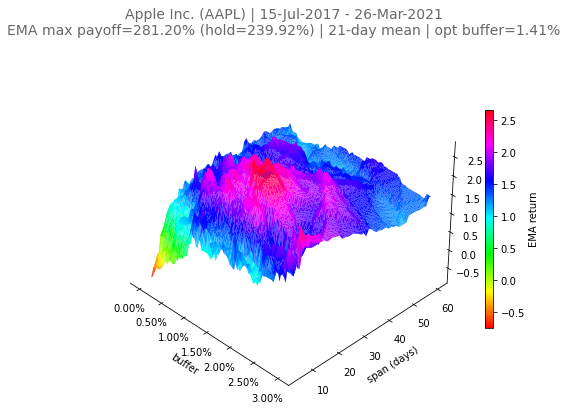

In [167]:
# Driver for plot_buffer_span_3D
%time 
plot = True
if plot:
    date_range = tra.get_datetime_date_range(security, START_DATE, END_DATE)
    if os.path.exists(tra.get_ema_map_filename(TICKER, date_range)):
        spans, buffers, emas, hold  = tra.read_ema_map(TICKER, date_range,)
    else: # If not saved, compute it
        spans, buffers, emas, hold = tra.build_ema_map(TICKER, security, date_range,)
    
    trp.plot_buffer_span_3D(TICKER, ticker_name, date_range, 
                                  spans, buffers, emas, hold,
                                  colors='hsv',
                                  azim=dft.PERSPECTIVE[0], 
                                  elev=dft.PERSPECTIVE[1], 
                                  rdist=dft.PERSPECTIVE[2],
                                 )

### Interactive plots

#### Widget defaults

In [80]:
def get_default_parameters(ticker, date_range):
    try: # ema file exists
        spans, buffers, emas, hold = tra.read_ema_map(ticker, date_range)
        df = tra.get_best_emas(spans, buffers, emas, hold, 1)
        opt_span, opt_buff , opt_ema, opt_hold = df.span[0], df.buffer[0], df.ema[0], df.hold[0]
    except Exception as ex:
        print(f'Could not process {ticker}: Exception={ex}') 
        raise ValueError('aborting')
        opt_span, opt_buff , opt_ema, opt_hold = dft.DEFAULT_SPAN, dft.DEFAULT_BUFFER, 0, 0 
    return opt_span, opt_buff , opt_ema, opt_hold

date_range = tra.get_datetime_date_range(security, START_DATE, END_DATE)
best_span, best_buffer, best_ema, hold = get_default_parameters(TICKER, date_range)
print(f'span={best_span:.0f}, buffer={best_buffer:.2%}, EMA={best_ema:.2%} hold={hold:.2%}')

span=21, buffer=1.41%, EMA=281.20% hold=239.92%


In [146]:
### Default parameter values
string_style = {'description_width': 'initial', 
                'handle_color':      'lawngreen'}

start_period, end_period = tra.get_datetime_date_range(security, START_DATE, END_DATE)
dates        = pd.date_range(start_period, end_period, freq='D')
date_options = [(date.strftime(' %d/%m/%Y'), date) for date in dates]
date_index   = (0, len(date_options) - 1)

best_span, best_buffer, _, _ = get_default_parameters(TICKER, date_range)

# Tx/broker's fee
min_fee     = 0.0
max_fee     = .01
delta_fee   = .0005
default_fee = dft.FEE_PCT

# of days for running mean
min_span     = dft.MIN_SPAN
max_span     = dft.MAX_SPAN
delta_span   = 1
default_span = best_span

# buffer around EMA
min_buffer     = dft.MIN_BUFF
max_buffer     = dft.MAX_BUFF
delta_buffer   = .0001
default_buffer = best_buffer

# number of maxima
max_value     = 15
default_value = 12

# 3D horizontal & vertical sliders
min_azimuth     = dft.MIN_AZIMUTH
max_azimuth     = dft.MAX_AZIMUTH
delta_azimuth   = 1
default_azimuth = dft.PERSPECTIVE[0]

min_elevation     = dft.MIN_ELEVATION
max_elevation     = dft.MAX_ELEVATION
delta_elevation   = 1
default_elevation = dft.PERSPECTIVE[1]

min_distance     = dft.MIN_DISTANCE
max_distance     = dft.MAX_DISTANCE
delta_distance   = 1
default_distance = dft.PERSPECTIVE[2]

color_schemes = dft.SURFACE_COLOR_SCHEMES

In [171]:
## Widget methods
### Sliders
def get_span_slider():
    return IntSlider(min      = min_span,
                     max      = max_span,
                     step     = delta_span,
                     value    = default_span,
                     style    = string_style,
                     disabled = False,
                     continuous_update=False,
                     readout=True,
                     readout_format='d',
                     layout = {'width': '250px'},
                    )

def get_buffer_slider():
    return FloatSlider(min=min_buffer,
                        max=max_buffer,
                        step=delta_buffer,
                        value=default_buffer,
                        style=string_style,
                        continuous_update=False,
                        disabled=False,
                        readout=True,
                        readout_format='.2%',
                        layout      = {'width': '250px'},
                       )
    
def get_fee_slider():
    return FloatSlider(min=min_fee,
                       max=max_fee,
                       step=delta_fee,
                       value=default_fee,
                       style=string_style,
                       disabled=False,
                       continuous_update=False,
                       readout=True,
                       readout_format='.2%',
                       layout      = {'width': '250px'},
                      )

def get_max_values_slider():
    return SelectionSlider(options=[x for x in range(0, max_value+1)],
                          value=default_value,
                          description='Number of maxima:',
                          style=string_style,
                          disabled=False,
                          continuous_update=False,
                          readout=True,
                          readout_format='d',
                          layout      = {'width': '500px'},
                          )
                       
def get_date_range_slider():
    return SelectionRangeSlider(options  = date_options,
                                 index   = date_index,
                                 description = 'Period:',
                                 orientation = 'horizontal',
                                 style       = string_style,
                                 layout      = {'width': '500px'}
                                )

def get_azimuth_slider():
    return IntSlider(min      = min_azimuth,
                     max      = max_azimuth,
                     step     = delta_azimuth,
                     value    = default_azimuth,
                     style    = string_style,
                     disabled = False,
                     continuous_update=False,
                     readout=True,
                     readout_format='d',
                     layout = {'width': '250px'},
                    )

def get_elevation_slider():
    return IntSlider(min      = min_elevation,
                     max      = max_elevation,
                     step     = delta_elevation,
                     value    = default_elevation,
                     style    = string_style,
                     disabled = False,
                     orientation='vertical',
                     continuous_update=False,
                     readout=True,
                     readout_format='d',
                     layout = {'height': '100px', 'width': '50px'},
                    )

def get_distance_slider():
    return IntSlider(min      = min_distance,
                     max      = max_distance,
                     step     = delta_distance,
                     value    = default_distance,
                     style    = string_style,
                     disabled = False,
                     continuous_update=False,
                     readout=True,
                     readout_format='d',
                     layout = {'width': '250px'},
                    )

### Text boxes
def get_fee_text_box():
    return FloatText(min=min_fee,
                     max=max_fee,
                     step=delta_fee,
                     value=default_fee,
                     description='Fees:',
                     style=string_style,
                     disabled=False,
                     readout_format='6.3%',
                     layout={'width': '150px'},
                    )
                       
def get_span_text_box():
    return IntText(min   = min_span,
                   max   = max_span,
                   step  = delta_span,
                   value = default_span,
                   style          = string_style,
                   disabled       = False,
                   description    = 'Span:',
                   readout_format = 'd',
                   layout={'width': '150px'},
                   )
                       
def get_buffer_text_box():
    return FloatText(min   = min_fee,
                     max   = max_fee,
                     step  = delta_fee,
                     value = default_fee,
                     style       = string_style,
                     disabled    = False,
                     description = 'Buffer:',
                     readout_format = '3%',
                     layout = {'width': '150px'},
                    )
def get_azimuth_text_box():
    return IntText(min   = min_azimuth,
                   max   = max_azimuth,
                   step  = delta_azimuth,
                   value = default_azimuth,
                   style          = string_style,
                   disabled       = False,
                   description    = 'Azimuth:',
                   readout_format = 'd',
                   layout={'width': '150px'},
                   )

def get_elevation_text_box():
    return IntText(min   = min_elevation,
                   max   = max_elevation,
                   step  = delta_elevation,
                   value = default_elevation,
                   style          = string_style,
                   disabled       = False,
                   description    = 'Elevation:',
                   readout_format = 'd',
                   layout={'width': '150px'},
                   )

def get_distance_text_box():
    return IntText(min   = min_distance,
                   max   = max_distance,
                   step  = delta_distance,
                   value = default_distance,
                   style          = string_style,
                   disabled       = False,
                   description    = 'Distance:',
                   readout_format = 'd',
                   layout={'width': '150px'},
                   )

# Dropdowns
def get_color_dropwdown():
    return Dropdown(options     = color_schemes,
                    value       = 'jet',
                    description = 'Color scheme:',
                    style       = string_style,
                    disabled    = False,
                    layout={'width': '250px'},
                    )


#### Interactive returns for window span

In [148]:
# Mean window span range optimizer interactive
buffer_slider   = get_buffer_slider()
buffer_text_box = get_buffer_text_box()
buffer_link     = jslink((buffer_slider, 'value'), (buffer_text_box, 'value'))

max_values_slider   = get_max_values_slider()

fee_slider   = get_fee_slider()
fee_text_box = get_fee_text_box()
fee_link     = jslink((fee_slider, 'value'), (fee_text_box, 'value'))

date_range_slider = get_date_range_slider()

fee_widgets    = HBox([fee_text_box, fee_slider])
buffer_widgets = HBox([buffer_text_box, buffer_slider])

out = interactive_output(plot_span_range,
                         {'buffer'    : buffer_slider,
                          'n_best'    : max_values_slider,
                          'fee_pct'   : fee_slider,
                          'date_range': date_range_slider,
                         }
                        )

ui = TwoByTwoLayout(top_left     = fee_widgets,
                    top_right    = date_range_slider,
                    bottom_left  = buffer_widgets,
                    bottom_right = max_values_slider,
                   )

display(ui, out)

TwoByTwoLayout(children=(HBox(children=(FloatText(value=0.004, description='Fees:', layout=Layout(width='150px…

Output()

#### Interactive returns for buffer size

In [149]:
# Buffer range optimizer interactive 
span_slider   = get_span_slider()
span_text_box = get_span_text_box()
span_link     = jslink((span_slider, 'value'), (span_text_box, 'value'))

max_values_slider = get_max_values_slider()

fee_slider   = get_fee_slider()
fee_text_box = get_fee_text_box()
fee_link     = jslink((fee_slider, 'value'), (fee_text_box, 'value'))

date_range_slider = get_date_range_slider()

fee_widgets    = HBox([fee_text_box, fee_slider])
span_widgets = HBox([span_text_box, span_slider])

out = interactive_output(plot_buffer_range,
                         {'span'      : span_slider,
                          'n_best'    : max_values_slider,
                          'fee_pct'   : fee_slider,
                          'date_range': date_range_slider,
                          }
                         )

ui = TwoByTwoLayout(top_left     = fee_widgets,
                    top_right    = date_range_slider,
                    bottom_left  = span_widgets,
                    bottom_right = max_values_slider,
                    )

display(ui, out)

TwoByTwoLayout(children=(HBox(children=(FloatText(value=0.004, description='Fees:', layout=Layout(width='150px…

Output()

#### Interactive buffer-span

In [150]:
# Buffer-span interactive plot
fee_slider   = get_fee_slider()
fee_text_box = get_fee_text_box()
fee_link     = jslink((fee_slider, 'value'), (fee_text_box, 'value'))

span_slider   = get_span_slider()
span_text_box = get_span_text_box()
span_link     = jslink((span_slider, 'value'), (span_text_box, 'value'))

buffer_slider   = get_buffer_slider()
buffer_text_box = get_buffer_text_box()
buffer_link     = jslink((buffer_slider, 'value'), (buffer_text_box, 'value'))

date_range_slider = get_date_range_slider()

out = interactive_output(plot_time_series,
                         {'span'      : span_slider,
                          'buffer'    : buffer_slider,
                          'fee_pct'   : fee_slider,
                          'date_range': date_range_slider,
                          }
                         )

fee_widgets    = HBox([fee_text_box, fee_slider])
span_widgets   = HBox([span_text_box, span_slider])
buffer_widgets = HBox([buffer_text_box, buffer_slider])

ui = TwoByTwoLayout(top_left     = fee_widgets,
                    top_right    = date_range_slider,
                    bottom_left  = span_widgets,
                    bottom_right = buffer_widgets,
                   )

display(ui, out)

TwoByTwoLayout(children=(HBox(children=(FloatText(value=0.004, description='Fees:', layout=Layout(width='150px…

Output()

#### Interactive 3D plot

In [172]:
# Buffer-span interactive plot
elevation_slider   = get_elevation_slider()
elevation_text_box = get_elevation_text_box()
elevation_link     = jslink((elevation_slider, 'value'), (elevation_text_box, 'value'))

azimuth_slider   = get_azimuth_slider()
azimuth_text_box = get_azimuth_text_box()
azimuth_link     = jslink((azimuth_slider, 'value'), (azimuth_text_box, 'value'))

distance_slider   = get_distance_slider()
distance_text_box = get_distance_text_box()
distance_link     = jslink((distance_slider, 'value'), (distance_text_box, 'value'))

color_dropdown    = get_color_dropwdown()

#date_range_slider = get_date_range_slider()

out = interactive_output(plot_buffer_span_3D,
                         {'azimuth'   : azimuth_slider,
                          'elevation' : elevation_slider,
                          'rdist'     : distance_slider,
                          'colors'    : color_dropdown,
                          }
                         )

azimuth_widgets   = VBox([azimuth_text_box, azimuth_slider])
elevation_widgets = VBox([elevation_text_box, elevation_slider])
distance_widgets  = VBox([distance_text_box, distance_slider])
h_widgets         = VBox([distance_widgets, azimuth_widgets])

ui = HBox([elevation_widgets, h_widgets, color_dropdown])

display(ui, out)

Output()